In [1]:
import torch
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from skimage.feature import hog
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show_random_images(dataset, num_images=25, grid_size=(5, 5), random_seed=None):
    """
    Display a grid of randomly selected images from a given dataset.

    Parameters:
        - dataset: Dataset object (e.g., torchvision.datasets.CIFAR100)
        - num_images: Number of images to display (default is 25)
        - grid_size: Tuple specifying the grid layout (e.g., (5, 5) for a 5x5 grid)
        - random_seed: Seed for reproducibility (default is None)
    """
    # Set random seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)

    # Get random indices for the images
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Create a grid of subplots
    fig, axes = plt.subplots(*grid_size, figsize=(10, 10))

    for i, ax in enumerate(axes.flatten()):
        # Get a random image and its label
        index = random_indices[i]
        image, label = dataset[index]
        # Display the image
        ax.imshow(image)
        ax.set_title(f"Label: {label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot a confusion matrix.

    Parameters:
        - y_true: True labels
        - y_pred: Predicted labels
        - classes: List of class names
    """
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(len(classes), len(classes)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()




In [3]:
data = datasets.CIFAR100('cifar100', train=True, download=True)

100%|██████████| 169001437/169001437 [00:06<00:00, 24221417.88it/s]


Extracting cifar100/cifar-100-python.tar.gz to cifar100


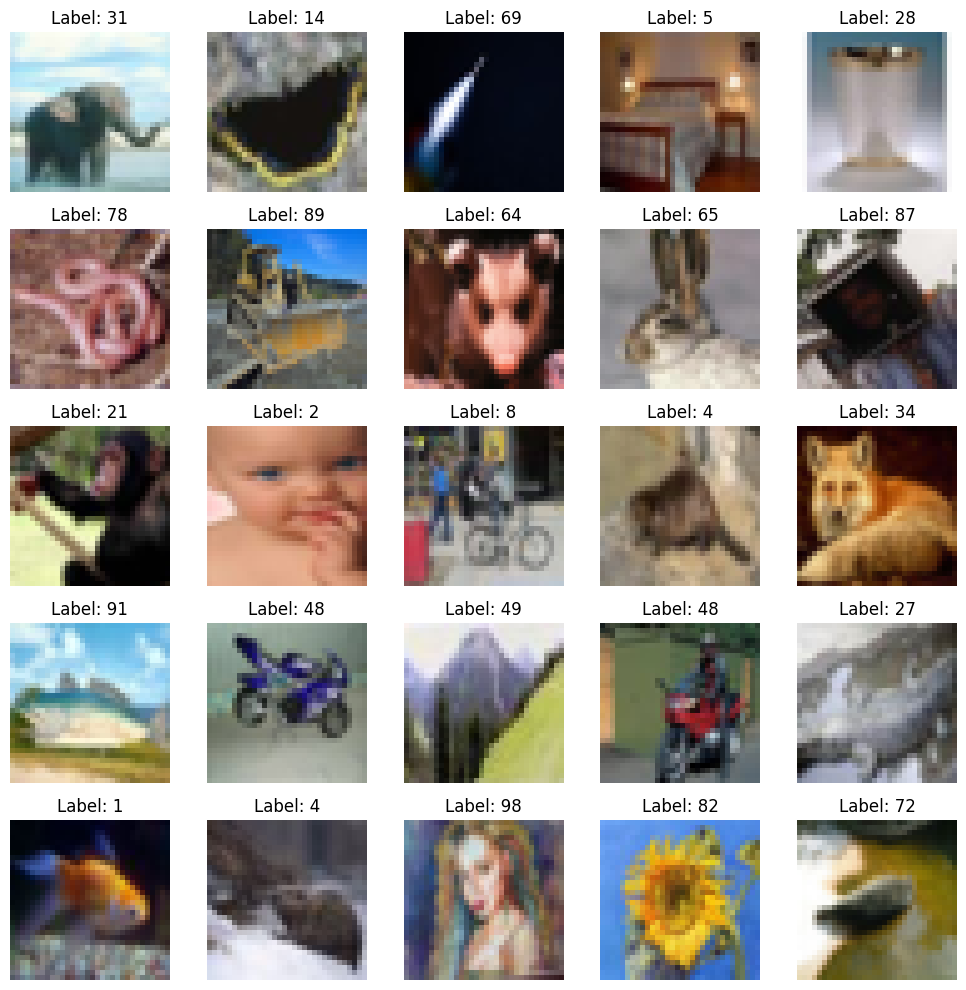

In [4]:
show_random_images(data)

In [5]:

cifar100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

In [6]:
selected_classes = [0, 1, 2, 3, 4]
selectedClassesLabels = cifar100_classes[:len(selected_classes)]
targets = [label for img, label in zip(data.data, data.targets) if label in selected_classes]

In [7]:
features = []
for img, label in zip(data.data, data.targets):
    if label in selected_classes:
        img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Extract HOG features for each image
        fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=False)

        # Flatten the HOG features and append them to the list
        features.append(fd.flatten())


<ipython-input-7-90dd6b35dcfc>:6: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=False)


In [8]:
len(features)

2500

In [9]:
X = np.array(features)
y = np.array(targets)

In [10]:
xTrain, xTest,yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
xTrain.shape, yTrain.shape

((2000, 32), (2000,))

In [12]:
data.data[0].shape

(32, 32, 3)

In [13]:
svm = SVC()
svm.fit(xTrain, yTrain)

SVC()

In [14]:
preds = svm.predict(xTest)

In [15]:
accuracy_score(yTest, preds)

0.396

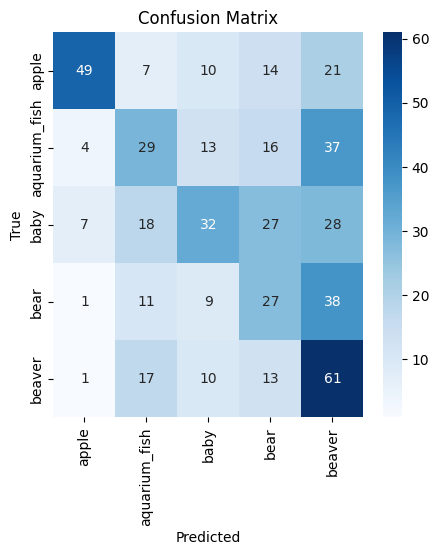

In [16]:
plot_confusion_matrix(yTest, preds, selectedClassesLabels)

### Deep learning CNN

In [17]:
selected_classes = [0, 1, 2, 3, 4]
selectedClassesLabels = cifar100_classes[:len(selected_classes)]
# Filter data for the selected classes
filterData = [img for img, label in zip(data.data, data.targets) if label in selected_classes]
targets = [label for img, label in zip(data.data, data.targets) if label in selected_classes]

In [18]:
filterData = np.array(filterData)
targets = np.array(targets)

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping

In [22]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(len(selected_classes), activation='softmax'))  # Assuming 5 classes

# Compile the model
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [24]:
xTrain, xTest, yTrain, yTest = train_test_split(filterData, targets, test_size=0.2, random_state=0)

In [25]:
history = model.fit(xTrain, yTrain, epochs=50)

Epoch 1/50
63/63 [==============================] - 5s 8ms/step - loss: 7.8248 - accuracy: 0.3795
Epoch 2/50
63/63 [==============================] - 0s 4ms/step - loss: 1.0807 - accuracy: 0.5765
Epoch 3/50
63/63 [==============================] - 0s 4ms/step - loss: 0.8645 - accuracy: 0.6615
Epoch 4/50
63/63 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.7540
Epoch 5/50
63/63 [==============================] - 0s 6ms/step - loss: 0.5029 - accuracy: 0.8055
Epoch 6/50
63/63 [==============================] - 0s 5ms/step - loss: 0.3553 - accuracy: 0.8770
Epoch 7/50
63/63 [==============================] - 0s 5ms/step - loss: 0.2905 - accuracy: 0.8900
Epoch 8/50
63/63 [==============================] - 0s 5ms/step - loss: 0.2038 - accuracy: 0.9415
Epoch 9/50
63/63 [==============================] - 0s 5ms/step - loss: 0.1613 - accuracy: 0.9500
Epoch 10/50
63/63 [==============================] - 0s 5ms/step - loss: 0.1293 - accuracy: 0.9590
Epoch 11/50
63/63 [

In [26]:
test_loss, test_accuracy = model.evaluate(xTest, yTest)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

16/16 [==============================] - 0s 11ms/step - loss: 2.5643 - accuracy: 0.7000
Test Accuracy: 70.00%


In [27]:
preds = model.predict(xTest)

16/16 [==============================] - 0s 2ms/step


16/16 [==============================] - 0s 2ms/step


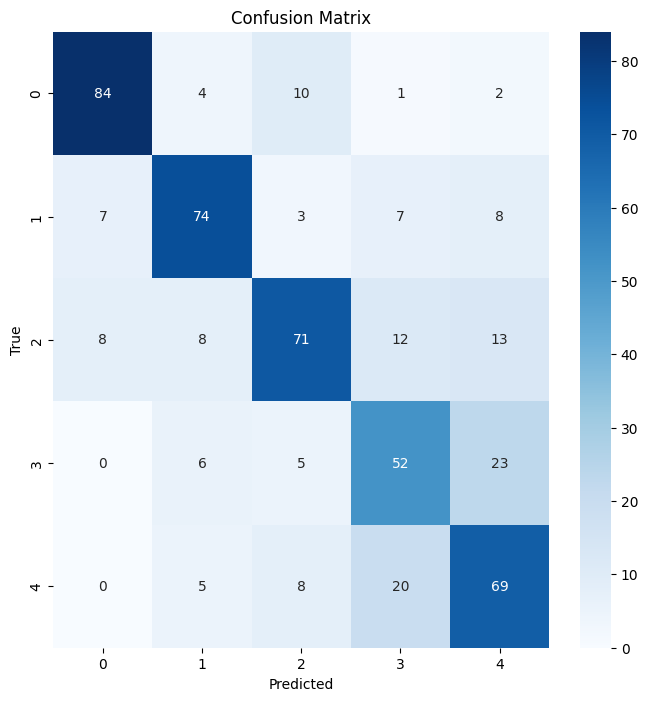

In [28]:
y_pred = np.argmax(model.predict(xTest), axis=1)
cm = confusion_matrix(yTest, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=selected_classes, yticklabels=selected_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Increasing classes to 50

In [29]:
selected_classes = [x for x in range(50)]
selectedClassesLabels = cifar100_classes[:len(selected_classes)]
# Filter data for the selected classes
# filterData = [img.flatten() for img, label in zip(data.data, data.targets) if label in selected_classes]
targets = [label for img, label in zip(data.data, data.targets) if label in selected_classes]

In [30]:
features = []
for img, label in zip(data.data, data.targets):
    if label in selected_classes:
        img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Extract HOG features for each image
        fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=False)

        # Flatten the HOG features and append them to the list
        features.append(fd.flatten())

<ipython-input-30-90dd6b35dcfc>:6: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=False)


In [31]:
len(features)

25000

In [32]:
X = np.array(features)
y = np.array(targets)

In [33]:
xTrain, xTest,yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=0)

In [34]:
svm = SVC()
svm.fit(xTrain, yTrain)

SVC()

In [35]:
preds = svm.predict(xTest)

In [36]:
accuracy_score(yTest, preds)

0.1654

In [ ]:
# plot_confusion_matrix(yTest, preds, selectedClassesLabels)

CNN on 50 classes

In [37]:
selected_classes = [x for x in range(50)]
selectedClassesLabels = cifar100_classes[:len(selected_classes)]
# Filter data for the selected classes
filterData = [img for img, label in zip(data.data, data.targets) if label in selected_classes]
targets = [label for img, label in zip(data.data, data.targets) if label in selected_classes]

In [38]:
filterData = np.array(filterData)
targets = np.array(targets)

In [39]:
print(len(filterData))
print(len(targets))

25000
25000


In [40]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='softmax'))  # Assuming 5 classes

# Compile the model
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [41]:
xTrain, xTest, yTrain, yTest = train_test_split(filterData, targets, test_size=0.2, random_state=0)

In [42]:
history = model.fit(xTrain, yTrain, epochs=50)

Epoch 1/50
625/625 [==============================] - 3s 3ms/step - loss: 4.1852 - accuracy: 0.1072
Epoch 2/50
625/625 [==============================] - 3s 5ms/step - loss: 2.9827 - accuracy: 0.2398
Epoch 3/50
625/625 [==============================] - 3s 4ms/step - loss: 2.4958 - accuracy: 0.3417
Epoch 4/50
625/625 [==============================] - 2s 4ms/step - loss: 2.1286 - accuracy: 0.4241
Epoch 5/50
625/625 [==============================] - 3s 4ms/step - loss: 1.7802 - accuracy: 0.5082
Epoch 6/50
625/625 [==============================] - 2s 3ms/step - loss: 1.4398 - accuracy: 0.5968
Epoch 7/50
625/625 [==============================] - 2s 3ms/step - loss: 1.1439 - accuracy: 0.6715
Epoch 8/50
625/625 [==============================] - 2s 4ms/step - loss: 0.9585 - accuracy: 0.7188
Epoch 9/50
625/625 [==============================] - 2s 3ms/step - loss: 0.7670 - accuracy: 0.7695
Epoch 10/50
625/625 [==============================] - 3s 5ms/step - loss: 0.6494 - accuracy: 0.8074

In [43]:
test_loss, test_accuracy = model.evaluate(xTest, yTest)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

157/157 [==============================] - 1s 3ms/step - loss: 20.9400 - accuracy: 0.2636
Test Accuracy: 26.36%


Creating more dense CNN model

In [44]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# Flatten layer to transition from convolutional to dense layers
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(50,activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [45]:
model.fit(xTrain,yTrain,epochs=50)

Epoch 1/50
625/625 [==============================] - 5s 4ms/step - loss: 3.9148 - accuracy: 0.0491
Epoch 2/50
625/625 [==============================] - 3s 4ms/step - loss: 3.3615 - accuracy: 0.1374
Epoch 3/50
625/625 [==============================] - 3s 5ms/step - loss: 3.0128 - accuracy: 0.2192
Epoch 4/50
625/625 [==============================] - 2s 4ms/step - loss: 2.7708 - accuracy: 0.2705
Epoch 5/50
625/625 [==============================] - 2s 4ms/step - loss: 2.5361 - accuracy: 0.3245
Epoch 6/50
625/625 [==============================] - 2s 4ms/step - loss: 2.3175 - accuracy: 0.3720
Epoch 7/50
625/625 [==============================] - 3s 4ms/step - loss: 2.1301 - accuracy: 0.4128
Epoch 8/50
625/625 [==============================] - 3s 5ms/step - loss: 1.9030 - accuracy: 0.4663
Epoch 9/50
625/625 [==============================] - 3s 4ms/step - loss: 1.7055 - accuracy: 0.5139
Epoch 10/50
625/625 [==============================] - 3s 4ms/step - loss: 1.5117 - accuracy: 0.5598

In [46]:
test_loss, test_accuracy = model.evaluate(xTest, yTest)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

157/157 [==============================] - 1s 3ms/step - loss: 10.5070 - accuracy: 0.2824
Test Accuracy: 28.24%
